In [4]:
import pandas as pd

# data = pd.read_csv("SHB_A-1987-01-02-2023-09-08.csv", sep=";", decimal=",", skiprows=1, encoding="utf-8")

# data.columns
column_order = ['Date', 'Bid', 'Ask', 'Opening price', 'High price', 'Low price', 'Closing price', 'Average price', 'Total volume', 'Turnover', 'Trades']
data = pd.read_csv("../../Data/Raw_data/SHB_A-1999-01-06-2024-02-05.csv", sep=";", decimal=",", skiprows=1, usecols=column_order)

pd.options.mode.chained_assignment = None  # default='warn'

            Closing price  Trades  Differenced Closing
Date                                                  
1999-01-07         39.111     336                  NaN
1999-01-08         38.889     231               -0.222
1999-01-11         37.778     175               -1.111
1999-01-12         36.944     256               -0.834
1999-01-13         35.611     321               -1.333
1999-01-14         35.389     359               -0.222
1999-01-15         36.444     368                1.055
1999-01-18         36.333     308               -0.111
1999-01-19         36.778     265                0.445
1999-01-20         36.667     348               -0.111
1999-01-21         35.000     521               -1.667
1999-01-22         34.778     348               -0.222
1999-01-25         34.500     308               -0.278
1999-01-26         34.889     401                0.389
1999-01-27         35.222     281                0.333
1999-01-28         34.500     338               -0.722
1999-01-29

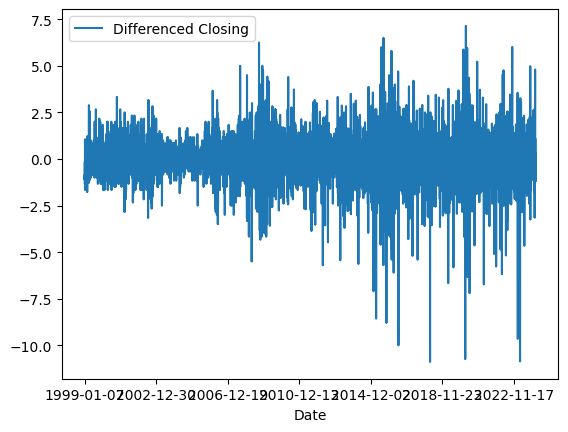

In [5]:
columns_to_drop = ["Bid", "Ask", "Opening price", "Average price"]
data = data.set_index("Date").drop(columns=columns_to_drop)

data = data.dropna(axis=1)

data = data[::-1]

data["Differenced Closing"] = data["Closing price"].diff()
    
data.plot.line(y="Differenced Closing")

print(data.to_string())

,Closing price,Trades,Differenced Closing
Date,,,
1999-01-08,38.889,231,-0.222
1999-01-11,37.778,175,-1.111
1999-01-12,36.944,256,-0.834
1999-01-13,35.611,321,-1.333
1999-01-14,35.389,359,-0.222
...,...,...,...
2024-01-29,113.300,5006,-1.100
2024-01-30,113.650,3750,0.350
2024-01-31,112.550,5316,-1.100


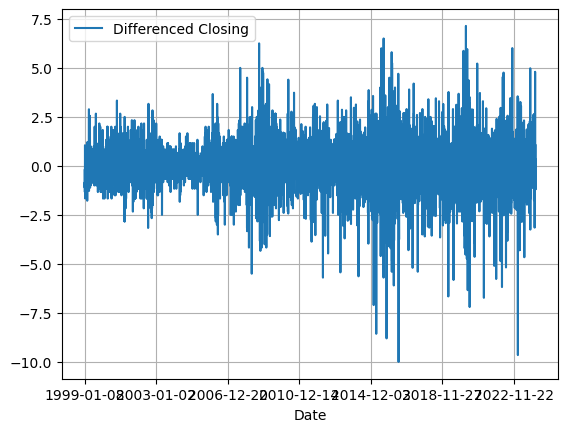

In [346]:
# Set a threshold for drastic price changes
drastic_change_threshold = 10  # You can adjust this threshold based on your data

# Create a boolean mask for rows with drastic price changes
mask = abs(data["Differenced Closing"]) <= drastic_change_threshold

# Apply the mask to filter out rows with drastic changes
data = data[mask]

data.plot.line(grid=True, y="Differenced Closing")
# Display the filtered data
data

In [347]:
import numpy as np

FACTOR = 0.0135 # Profit to define target 0.014
SEQUENCE_LENGTH = 10
HORIZON = 2

SHORT_CHANGE_HORIZON = 5
MID_CHANGE_HORIZON = 20
LONG_CHANGE_HORIZON = 50
FACTOR = 0.0135 # Profit to define target 0.014

data["Short_day_change"] = (data["Closing price"] - data["Closing price"].shift(SHORT_CHANGE_HORIZON)) / SHORT_CHANGE_HORIZON
data["Mid_day_change"] = (data["Closing price"] - data["Closing price"].shift(MID_CHANGE_HORIZON)) / MID_CHANGE_HORIZON
data["Long_day_change"] = (data["Closing price"] - data["Closing price"].shift(LONG_CHANGE_HORIZON)) / LONG_CHANGE_HORIZON


data["t+1"] = data["Closing price"].shift(-1)
data["t+2"] = data["Closing price"].shift(-2)
data["t+3"] = data["Closing price"].shift(-3)
data["t+4"] = data["Closing price"].shift(-4)
data["t+5"] = data["Closing price"].shift(-5)

conditions = [
    (data["t+1"] > (data["Closing price"] * (1+FACTOR))) |
    (data["t+2"] > (data["Closing price"] * (1+FACTOR))) |
    (data["t+3"] > (data["Closing price"] * (1+FACTOR))) |
    (data["t+4"] > (data["Closing price"] * (1+FACTOR))) |
    (data["t+5"] > (data["Closing price"] * (1+FACTOR)))
]


choice = [1]
data["Target"] = np.select(conditions, choice, 0)

data = data.dropna()

data["Target"].value_counts()

0    3136
1    3111
Name: Target, dtype: int64

In [348]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

SEQUENCE_LENGTH = 5

prices = data["Differenced Closing"].values
target = data["Target"].values

X = []
y = []

for i in range(len(data) - SEQUENCE_LENGTH):
    X.append(prices[i:i+SEQUENCE_LENGTH])
    y.append(target[i])

X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], X.shape[1], 1)

print("X " , X.shape)
print("y ", y.shape)

TRAIN_RATIO = 0.8
split_ix = int(len(data) * TRAIN_RATIO)

# Split data into training and validation sets
X_train, X_val = X[:split_ix], X[split_ix:]
y_train, y_val = y[:split_ix], y[split_ix:]

print(X_val.shape)

X  (6242, 5, 1)
y  (6242,)
(1245, 5, 1)


In [349]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

samples, sequence_length, features = X_train.shape

# Scale the reshaped data
scaler = MinMaxScaler(feature_range=(0,1))

X_train_reshaped = X_train.reshape(samples * sequence_length, features)
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(samples, sequence_length, features)

# Repeat the same process for X_val
X_val_reshaped = X_val.reshape(X_val.shape[0] * sequence_length, features)
X_val_scaled = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled.reshape(X_val.shape[0], sequence_length, features)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5835 - mean_absolute_error: 0.4284
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3672 - mean_absolute_error: 0.2523
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3304 - mean_absolute_error: 0.2179
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3220 - mean_absolute_error: 0.2097
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3089 - mean_absolute_error: 0.2021
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3036 - mean_absolute_error: 0.1935
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2981 - mean_absolute_error: 0.1890
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2940 - mean_absolute_error: 0.1911
Epoch 9/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2993 - mean_absolute_error: 0.1895
Epoch 10/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2830 - mean_absolute_error: 0.1822
Epoch 11/30
157/157 ━━━━━━━━━

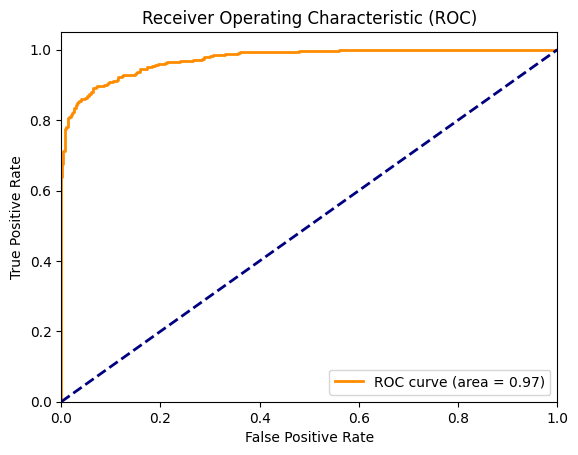

In [350]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Step 3: Build the LSTM Model
model = Sequential()
model.add(Input(shape=(SEQUENCE_LENGTH, 1)))
model.add(LSTM(units=40))
model.add(Dense(units=1, activation='sigmoid'))

# Step 4: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['mean_absolute_error'])


# Step 5: Train the Model
# history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))
history = model.fit(X_train, y_train, epochs=30, batch_size=32)
# Step 6: Evaluate the Model
# loss, mae = model.evaluate(X_val, y_val)
# print("Test Loss:", loss)
# print("Mean Absolute Error:", mae)

# # Plot training and validation loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# Make predictions
y_pred = model.predict(X_val)

# For binary classification
y_pred_binary = (y_pred > 0.5).astype(int)
# Convert continuous values to binary labels using a threshold (e.g., 0.5)
y_val_binary = (y_val > 0.5).astype(int)


accuracy = accuracy_score(y_val_binary, y_pred_binary)
precision = precision_score(y_val_binary, y_pred_binary)
recall = recall_score(y_val_binary, y_pred_binary)
f1 = f1_score(y_val_binary, y_pred_binary)

conf_matrix = confusion_matrix(y_val_binary, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val_binary, y_pred)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [357]:

total = len(y_val_binary)
correct = 0
for x, val in enumerate(y_val_binary):
    print("Pred: ", y_pred_binary[x][0], "Actual: ", y_val_binary[x])
    if y_pred_binary[x][0] == y_val_binary[x]:
        correct += 1

print(correct / total)


Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  0
Pred:  1 Actual:  1
Pred:  1 Actual:  0
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  0
Pred:  1 Actual:  0
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  0 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  1 Actual:  0
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  0
Pred:  0 Actual:  0
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  1 Actual:  1
Pred:  0 Actual:  0
Pred:  0 Actual:  0
Pred:  1 Actual:  1


In [352]:
import joblib


# Save the trained model
model.save("my_model.keras")

# Save the fitted scaler
joblib.dump(scaler, "my_scaler.pkl")

['my_scaler.pkl']